# Microstructure characterization of battery materials based on voxelated image data: Computation of active surface area and tortuosity

## Battery microstructures

The study is complemented by three realistic microstructures, namely a
representative volume element of nano-porous NVP-C [Neumann et. al. 2024](https://chemistry-europe.onlinelibrary.wiley.com/doi/10.1002/batt.202300409) which is a promising cathode
material for sodium ion batteries, a section from a commercial NMC
electrode from x-ray tomography [Usseglio-Viretta et. al. 2018](https://iopscience.iop.org/article/10.1149/2.0731814jes/pdf) and a biphasic iron-graphite structure from [microlib](https://microlib.io) to underline the generality of the used methods.
<br>


<p style="display: inline-block; margin-right: 10px;">
  <img src="data-paper/battery-structures/nanoporous-NVP.png" alt="Image 1" width="300" />
</p>
<p style="display: inline-block; margin-right: 10px;">
  <img src="data-paper/battery-structures/xray-electrode-CBD.png" alt="Image 1" width="300" />
</p>
<p style="display: inline-block; margin-right: 10px;">
  <img src="data-paper/battery-structures/graphite-ferrite.png" alt="Image 1" width="300" />
</p>


**Author**: Simon Daubner<br>

In [1]:
import numpy as np
import tifffile

import metrics
import data
import time

### Full electrode example: NMC commercial electrode

In [2]:
path_to_tif = "data-paper/battery-structures/nmc-1-cal-withcbd-w099-binarized.tif"
tif_file = tifffile.imread(path_to_tif)
structure = np.array(tif_file)
structure = structure[20:-20,20:-20,20:-20]
print("Stack shape:", structure.shape)

labels = {"pore":0, "NMC":1, "CBD":2}
px = 398e-9 # pixel resolution in m

Stack shape: (213, 213, 213)


### NVP-C: nanoporous cathode material for sodium ion batteries

In [3]:
# path_to_images = "../VirtualStructures/Model_NVP_60/Model_NVP_60_VolC_150_N=01"
# path_to_images = "../VirtualStructures/Model_NVP_60/Model_NVP_60_VolC_275_N=01"
# path_to_images = "../VirtualStructures/Model_NVP_60/Model_NVP_60_VolC_300_N=01"
# structure = data.read_image_stack_pgm(path_to_images)
# print("Stack shape:", structure.shape)

# NVP = 255, carbon = 0, pore = 155
# labels = {"NVP":255, "carbon":0, "pore":155}
# px = 16.6e-9 # pixel resolution in m

### Biphasic iron-graphite structure from [microlib](https://microlib.io)

**Description:** The addition of a substantial amount of silicon to a relatively low carbon cast iron serves to induce the cementite to transform to ferrite and graphite flakes. This results in the properties of the resultant metal being more similar to that of grey cast iron, i.e. making it easier to machine and improving wear resistance.<br>
**Contributor:** Dr R F Cochrane<br>
**Organisation:** Department of Materials, University of Leeds<br>
**Voxel size:** 1.375 µm

In [4]:
#path_to_tif = "/.../microstructure378.tif"
#tif_file = tifffile.imread(path_to_tif)
#structure = np.array(tif_file)
#print("Stack shape:", structure.shape)

#labels = {"ferrite":1, "graphite":0}
#px = 1.375e-6 # pixel resolution in m

### Generic script for microstructure metrics

Load one of the three samples above or try your own data. The following code snippets will extract the

- volume fraction,
- surface area,
- pairwise-surface area,
- through-feature connectivities and
- tortuosity factors

of all phases defined by the `labels` dictionary.

#### Volume fractions

In [5]:
volume_fraction = {}

for key, value in labels.items():
    # Compute volume fraction of full datset
    volume_fraction[key] = metrics.volume_fraction(structure , value)
    print(f"Volume fraction of {key}: {volume_fraction[key]:.4f}")

Volume fraction of pore: 0.3598
Volume fraction of NMC: 0.5062
Volume fraction of CBD: 0.1340


#### Surface areas

In [6]:
surface = {}
for key, value in labels.items():
    timer = []
    timer.append(time.time())
    smooth_field = metrics.smooth_with_convolution((structure == value).astype(float))
    area_marching = metrics.specific_surface_area_marching(smooth_field, voxel_size=px)
    timer.append(time.time())
    surface[key] = metrics.specific_surface_area((structure == value).astype(float), dx=px, dy=px, dz=px, smooth=1)
    timer.append(time.time())
    print(f"Specific surface area of {key}: {surface[key]*1e-6:.5f} [1/µm]")
    print(f"Rel. difference marching vs. gradient: eps_a={(area_marching-surface[key])/surface[key]:.5f}, t={timer[2]-timer[1]:.3f}s vs {timer[1]-timer[0]:.3f}s")
print()

for key1, value in labels.items():
    for key2, value in labels.items():
        if key1 != key2:
            for key3, value in labels.items():
                if key3 != key2 and key3 != key1:
                    area12 = 0.5*(surface[key1] + surface[key2] - surface[key3])
                    area13 = 0.5*(surface[key1] + surface[key3] - surface[key2])
                    area23 = 0.5*(surface[key2] + surface[key3] - surface[key1])
                    print(f"Specific surface area of {key1}-{key2}:  {area12*1e-6:.5f} [1/µm]")
                    print(f"Specific surface area of {key1}-{key3}:  {area13*1e-6:.5f} [1/µm]")
                    print(f"Specific surface area of {key2}-{key3}:  {area23*1e-6:.5f} [1/µm]")
            break
    break

Specific surface area of pore: 0.30090 [1/µm]
Rel. difference marching vs. gradient: eps_a=0.12438, t=0.222s vs 1.258s
Specific surface area of NMC: 0.24761 [1/µm]
Rel. difference marching vs. gradient: eps_a=-0.00260, t=0.221s vs 0.914s
Specific surface area of CBD: 0.31347 [1/µm]
Rel. difference marching vs. gradient: eps_a=0.24328, t=0.221s vs 1.414s

Specific surface area of pore-NMC:  0.11752 [1/µm]
Specific surface area of pore-CBD:  0.18338 [1/µm]
Specific surface area of NMC-CBD:  0.13009 [1/µm]


#### Through feature connectivity

In [7]:
through_fraction = {}
for key, value in labels.items():
    through_fraction[key] = {}
    _, through_fraction[key]['x'] = metrics.extract_through_feature(structure, value, 'x')
    _, through_fraction[key]['y'] = metrics.extract_through_feature(structure, value, 'y')
    _, through_fraction[key]['z'] = metrics.extract_through_feature(structure, value, 'z')

print( "With |  side  |  edge  | corner | connectivity")
for key, value in labels.items():
    print(f" x = | {through_fraction[key]['x'][0]:.4f} | {through_fraction[key]['x'][1]:.4f} | {through_fraction[key]['x'][2]:.4f} | % of {key} are connected")
    print(f" y = | {through_fraction[key]['y'][0]:.4f} | {through_fraction[key]['y'][1]:.4f} | {through_fraction[key]['y'][2]:.4f} | % of {key} are connected")
    print(f" z = | {through_fraction[key]['z'][0]:.4f} | {through_fraction[key]['z'][1]:.4f} | {through_fraction[key]['z'][2]:.4f} | % of {key} are connected")

With |  side  |  edge  | corner | connectivity
 x = | 0.9898 | 0.9978 | 0.9987 | % of pore are connected
 y = | 0.9898 | 0.9978 | 0.9987 | % of pore are connected
 z = | 0.9898 | 0.9978 | 0.9987 | % of pore are connected
 x = | 0.9974 | 0.9985 | 0.9985 | % of NMC are connected
 y = | 0.9974 | 0.9985 | 0.9985 | % of NMC are connected
 z = | 0.9974 | 0.9985 | 0.9985 | % of NMC are connected
 x = | 0.9772 | 0.9940 | 0.9963 | % of CBD are connected
 y = | 0.9772 | 0.9940 | 0.9963 | % of CBD are connected
 z = | 0.9772 | 0.9940 | 0.9963 | % of CBD are connected


#### Tortuosity factors

In [8]:
tau = {}
for key, value in labels.items():
    tau_vgl = metrics.tortuosity(structure == value, run_on='cuda')
    through_feature, through_fraction = metrics.extract_through_feature(structure, value, 'x', connectivity=1)
    tau[key] = metrics.tortuosity(through_feature[0], run_on='cuda')
    print(f"Tortuosity factor of {key} in x: {tau[key]/through_fraction[0]:.5f} ({tau_vgl:.5f}).")
    tau_vgl = metrics.tortuosity(np.transpose(structure == value, (1,0,2)), run_on='cuda')
    through_feature, through_fraction = metrics.extract_through_feature(structure, value, 'y', connectivity=1)
    tau[key] = metrics.tortuosity(np.transpose(through_feature[0], (1,0,2)), run_on='cuda')
    print(f"Tortuosity factor of {key} in y: {tau[key]/through_fraction[0]:.5f} ({tau_vgl:.5f}).")
    tau_vgl = metrics.tortuosity(np.transpose(structure == value, (2,0,1)), run_on='cuda')
    through_feature, through_fraction = metrics.extract_through_feature(structure, value, 'z', connectivity=1)
    tau[key] = metrics.tortuosity(np.transpose(through_feature[0], (2,0,1)), run_on='cuda')
    print(f"Tortuosity factor of {key} in z: {tau[key]/through_fraction[0]:.5f} ({tau_vgl:.5f}).")

converged to: 2.707766532897949                   after: 1401 iterations in: 2.1203                    seconds at a rate of 0.0015 s/iter
converged to: 2.680253744125366                   after: 1401 iterations in: 2.1106                    seconds at a rate of 0.0015 s/iter
Tortuosity factor of pore in x: 2.70777 (2.70777).
converged to: 2.7996749877929688                   after: 1301 iterations in: 1.9595                    seconds at a rate of 0.0015 s/iter
converged to: 2.771228551864624                   after: 1301 iterations in: 1.9594                    seconds at a rate of 0.0015 s/iter
Tortuosity factor of pore in y: 2.79968 (2.79967).
converged to: 3.2961585521698                   after: 1301 iterations in: 1.9595                    seconds at a rate of 0.0015 s/iter
converged to: 3.2626686096191406                   after: 1301 iterations in: 1.9596                    seconds at a rate of 0.0015 s/iter
Tortuosity factor of pore in z: 3.29616 (3.29616).
converged to: 2.323

### Feature resolution

A segementation of each phases into its features (e.g. spherical particles) is performed using the [SNOW segmentation](https://porespy.org/modules/generated/generated/porespy.filters.snow_partitioning.html) combined with subsequent analysis to quantify the uncertainty of the extracted metrics. All features that are touching the domain boundaries are excluded to remove artefacts.

Note that the SNOW segmentation employs a spherical structuring element with radius r (in pixels) to avoid over-segmentation. For phases which are not well-resolved on the voxel grid (e.g. the CBD in the first example), this results in drastic changes of the resulting segmentation.

In [9]:
import porespy as ps

radii_r3 = {}
surf_marching_r3 = {}
surf_gradient_r3 = {}
radii_r4 = {}
surf_marching_r4 = {}
surf_gradient_r4 = {}
box_volume = np.prod(structure.shape)

for key, value in labels.items():
    snow_labels = (ps.filters.snow_partitioning(structure == value, r_max=3)).regions
    data.extract_inner_features(snow_labels)
    # Re-label to ensure consecutive order of integers
    snow_relabelled = data.relabel_random_order(snow_labels)

    snow_volumes=ps.metrics.region_volumes(snow_relabelled, mode='voxel')
    # Compute equivalent pixel radius assuming spherical feature shape
    radii_r3[key] = (3/4*snow_volumes/np.pi)**(1/3)

    timer = []
    timer.append(time.time())
    surf_marching_r3[key] = ps.metrics.region_surface_areas(snow_relabelled)/box_volume
    timer.append(time.time())
    surf_gradient_r3[key] = metrics.specific_surface_areas_torch(snow_relabelled, device='cuda')
    timer.append(time.time())
    print(f"Porespy computation took: {timer[1]-timer[0]}s")
    print(f"Gradient method took: {timer[2]-timer[1]}s")

for key, value in labels.items():
    snow_labels = (ps.filters.snow_partitioning(structure == value)).regions
    data.extract_inner_features(snow_labels)
    # Re-label to ensure consecutive order of integers
    snow_relabelled = data.relabel_random_order(snow_labels)

    snow_volumes=ps.metrics.region_volumes(snow_relabelled, mode='voxel')
    # Compute equivalent pixel radius assuming spherical feature shape
    radii_r4[key] = (3/4*snow_volumes/np.pi)**(1/3)

    timer = []
    timer.append(time.time())
    surf_marching_r4[key] = ps.metrics.region_surface_areas(snow_relabelled)/box_volume
    timer.append(time.time())
    surf_gradient_r4[key] = metrics.specific_surface_areas_torch(snow_relabelled, device='cuda')
    timer.append(time.time())
    print(f"Porespy computation took: {timer[1]-timer[0]}s")
    print(f"Gradient method took: {timer[2]-timer[1]}s")

0it [00:00, ?it/s]

1897 of initial 2687 labels remaining.


Computing region volumes                                    :   0%|          | 0/1896 [00:00<?, ?it/s]

Computing region surface area                               :   0%|          | 0/1896 [00:00<?, ?it/s]

Porespy computation took: 18.620730876922607s
Gradient method took: 2.5843937397003174s


0it [00:00, ?it/s]

481 of initial 878 labels remaining.


Computing region volumes                                    :   0%|          | 0/480 [00:00<?, ?it/s]

Computing region surface area                               :   0%|          | 0/480 [00:00<?, ?it/s]

Porespy computation took: 5.1682820320129395s
Gradient method took: 0.7165343761444092s


0it [00:00, ?it/s]

4 of initial 50 labels remaining.


Computing region volumes                                    :   0%|          | 0/3 [00:00<?, ?it/s]

Computing region surface area                               :   0%|          | 0/3 [00:00<?, ?it/s]

Porespy computation took: 0.15213751792907715s
Gradient method took: 0.1441662311553955s


0it [00:00, ?it/s]

1294 of initial 1959 labels remaining.


Computing region volumes                                    :   0%|          | 0/1293 [00:00<?, ?it/s]

Computing region surface area                               :   0%|          | 0/1293 [00:00<?, ?it/s]

Porespy computation took: 12.941426992416382s
Gradient method took: 1.264183759689331s


0it [00:00, ?it/s]

471 of initial 851 labels remaining.


Computing region volumes                                    :   0%|          | 0/470 [00:00<?, ?it/s]

Computing region surface area                               :   0%|          | 0/470 [00:00<?, ?it/s]

Porespy computation took: 5.069008111953735s
Gradient method took: 0.5204300880432129s


0it [00:00, ?it/s]

4 of initial 50 labels remaining.


Computing region volumes                                    :   0%|          | 0/3 [00:00<?, ?it/s]

Computing region surface area                               :   0%|          | 0/3 [00:00<?, ?it/s]

Porespy computation took: 0.15247130393981934s
Gradient method took: 0.15424704551696777s


#### Plot histogram of feature radii

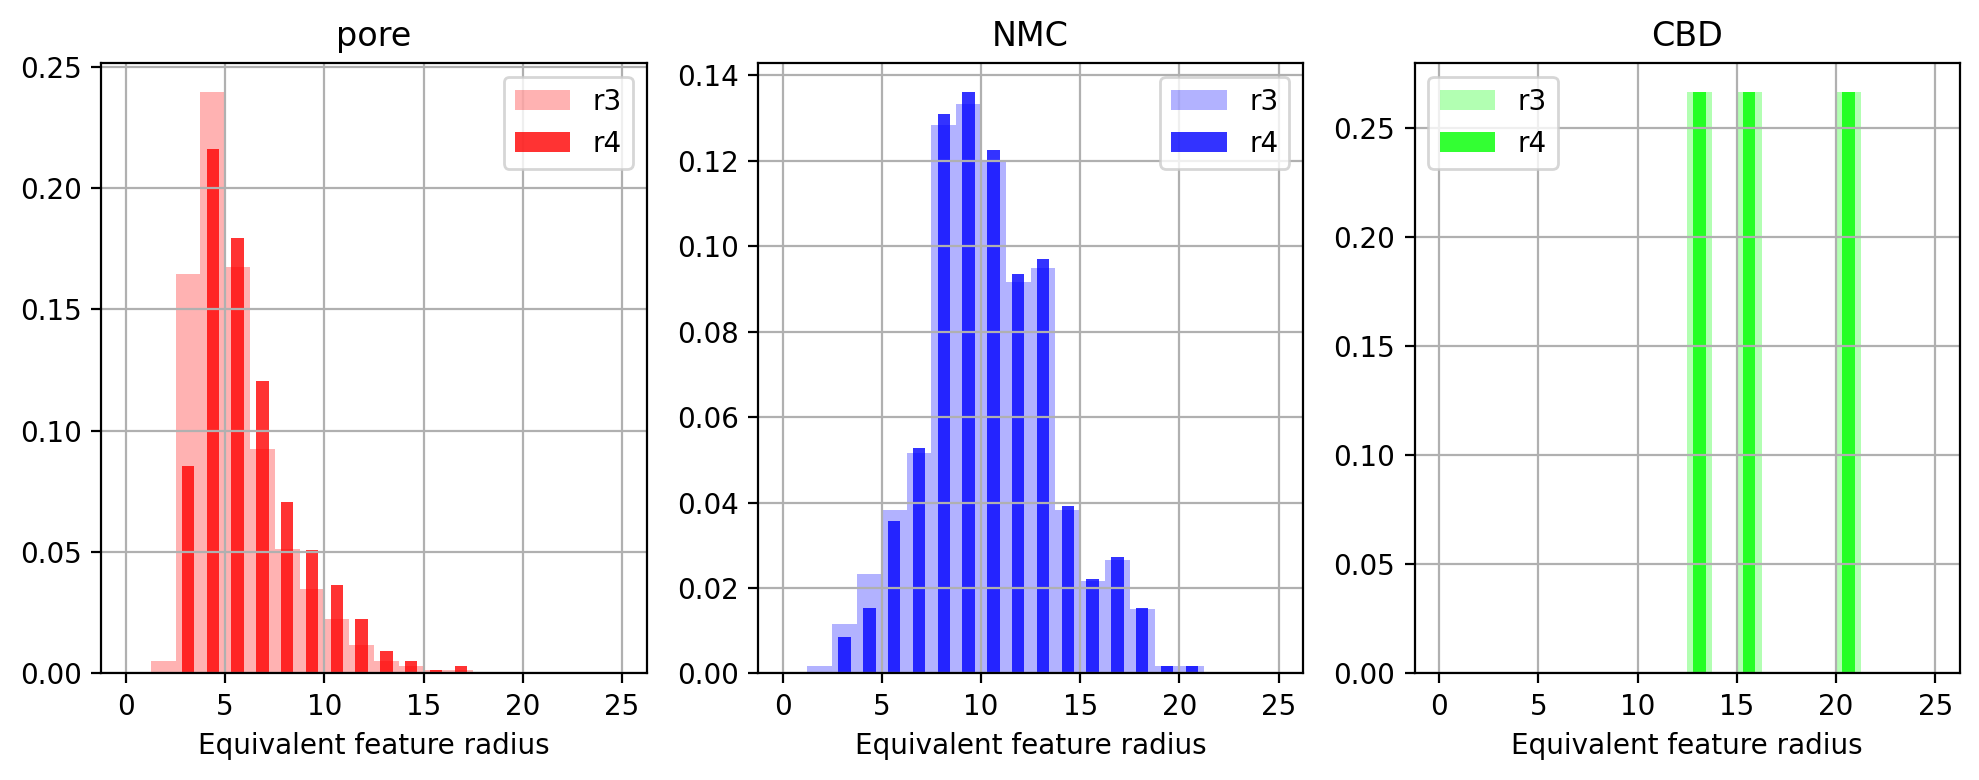

In [10]:
import matplotlib.pyplot as plt
colors = ['red', 'blue', 'lime']

fig, ((ax0, ax1, ax2)) = plt.subplots(nrows=1, ncols=3, figsize=(10, 4), dpi=200)
axes = [ax0, ax1, ax2]
range = 25
bins = 20
i = 0
for key, value in labels.items():
    axes[i].hist(radii_r3[key], bins=bins, density=True, range=(0,range), alpha=0.3, label='r3', color=colors[i])
    axes[i].hist(radii_r4[key], bins=bins, rwidth=0.5, density=True, range=(0,range), alpha=0.8, label='r4', color=colors[i])
    axes[i].set_title(key)
    axes[i].set_xlabel('Equivalent feature radius')
    axes[i].legend()
    axes[i].grid()
    i = i + 1
plt.tight_layout()
plt.show()

**Compute mean and export histograms**

In [11]:
for key, value in labels.items():
    print("Mean of radii distribution of "+key+f" is {np.mean(radii_r4[key])}.")

for key, value in labels.items():
    name = 'volumes_hist_'+key+'.txt'
    data.export_histogram(radii_r4[key], bins=bins, density=True, range=(0,range), filename=name)

Mean of radii distribution of pore is 6.281256917438124.
Mean of radii distribution of NMC is 10.527008498867001.
Mean of radii distribution of CBD is 16.165517077607575.


#### Plot histogram of surface areas

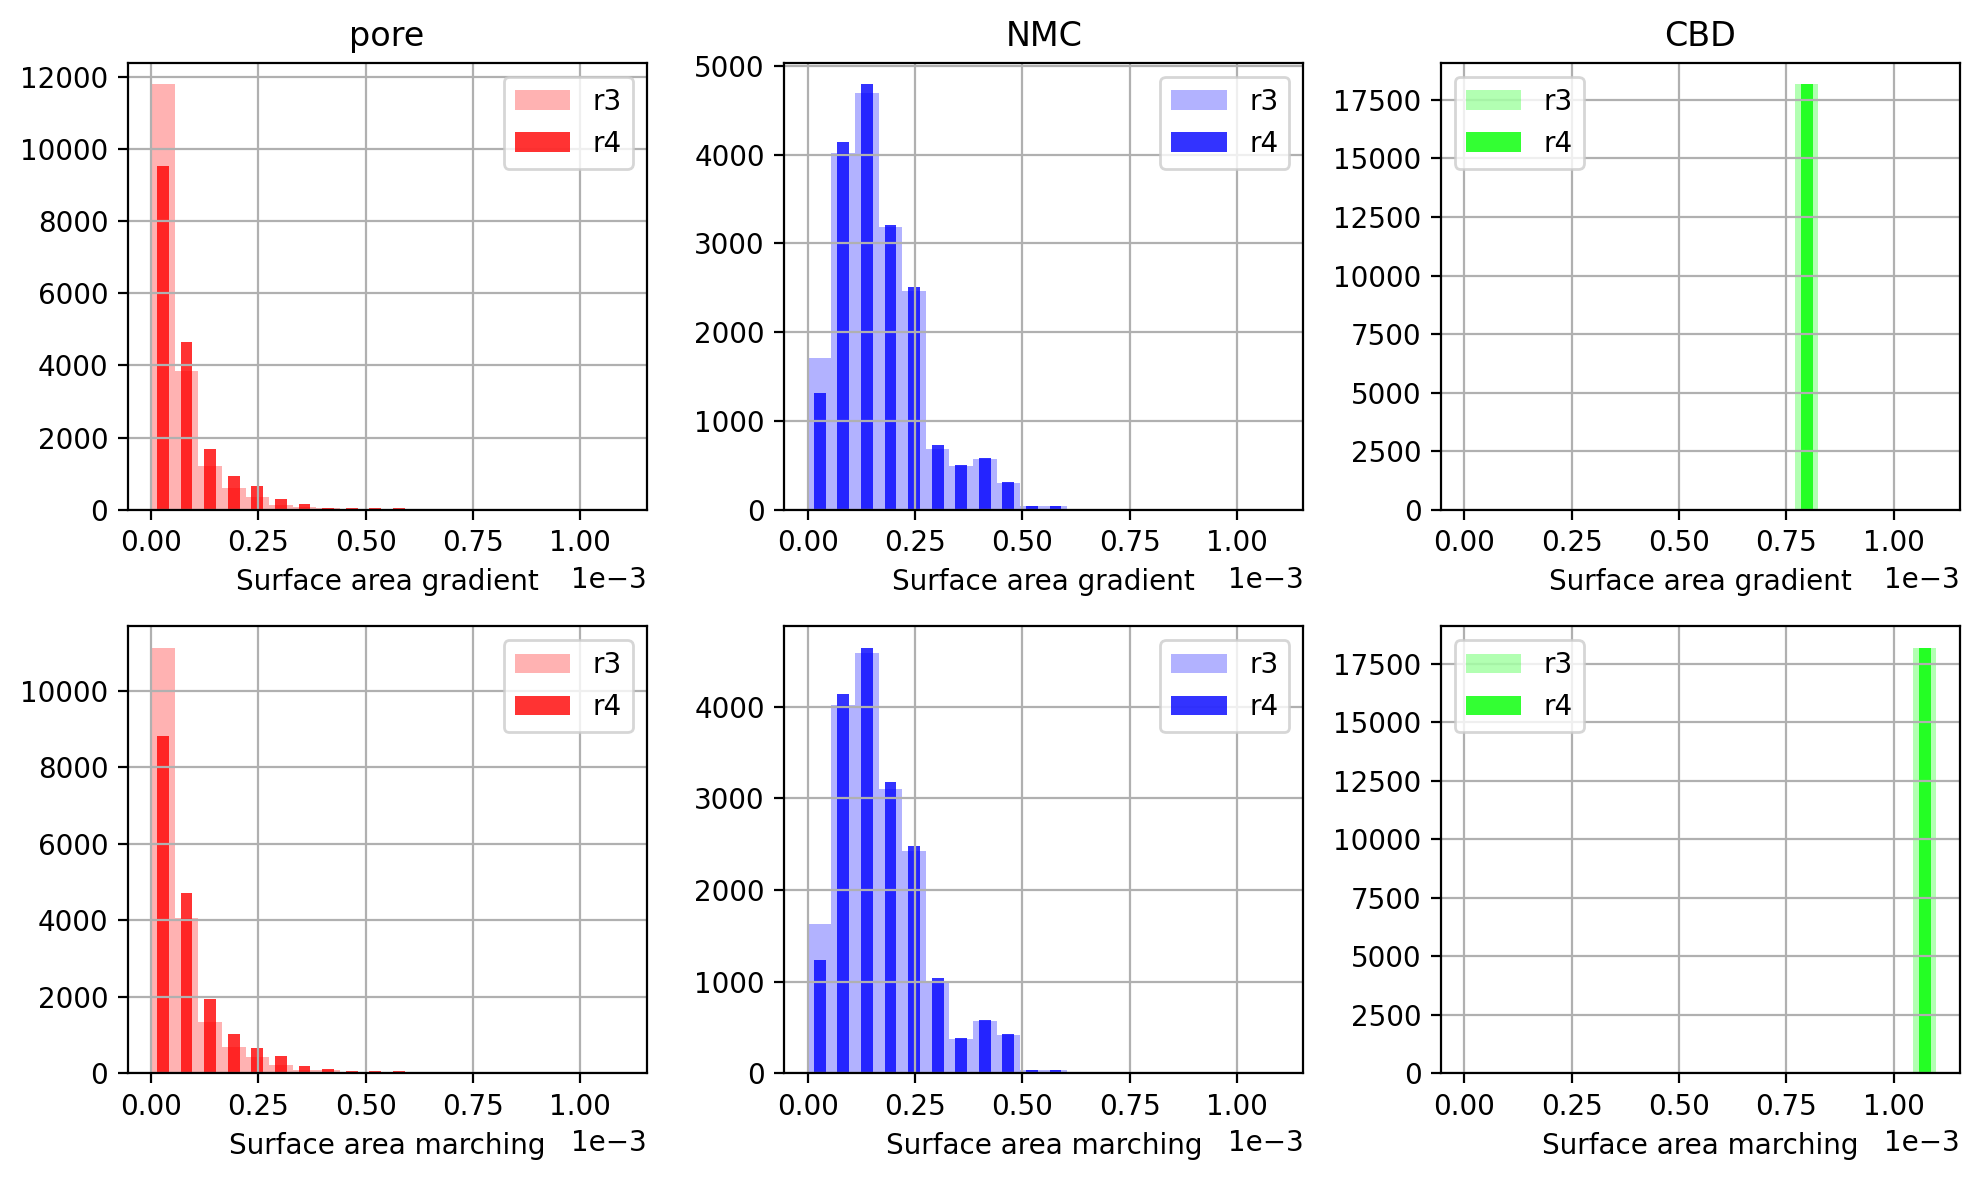

In [12]:
colors = ['red', 'blue', 'lime', 'red', 'blue', 'lime']

fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(nrows=2, ncols=3, figsize=(10, 6), dpi=200)
axes = [ax0, ax1, ax2, ax3, ax4, ax5]
range = 11e-4
i = 0
for key, value in labels.items():
    axes[i].hist(surf_gradient_r3[key], bins=20, density=True, range=(0,range), alpha=0.3, label='r3', color=colors[i])
    axes[i].hist(surf_gradient_r4[key], bins=20, rwidth=0.5, density=True, range=(0,range), alpha=0.8, label='r4', color=colors[i])
    axes[i].set_title(key)
    axes[i].set_xlabel('Surface area gradient')
    axes[i].ticklabel_format(style='sci', axis='x', scilimits=(-3, 3))
    axes[i].legend()
    axes[i].grid()
    i = i + 1

for key, value in labels.items():
    axes[i].hist(surf_marching_r3[key], bins=20, density=True, range=(0,range), alpha=0.3, label='r3', color=colors[i])
    axes[i].hist(surf_marching_r4[key], bins=20, rwidth=0.5, density=True, range=(0,range), alpha=0.8, label='r4', color=colors[i])
    axes[i].set_xlabel('Surface area marching')
    axes[i].ticklabel_format(style='sci', axis='x', scilimits=(-3, 3))
    axes[i].legend()
    axes[i].grid()
    i = i + 1
plt.tight_layout()
plt.show()

#### Histogram of sphericity

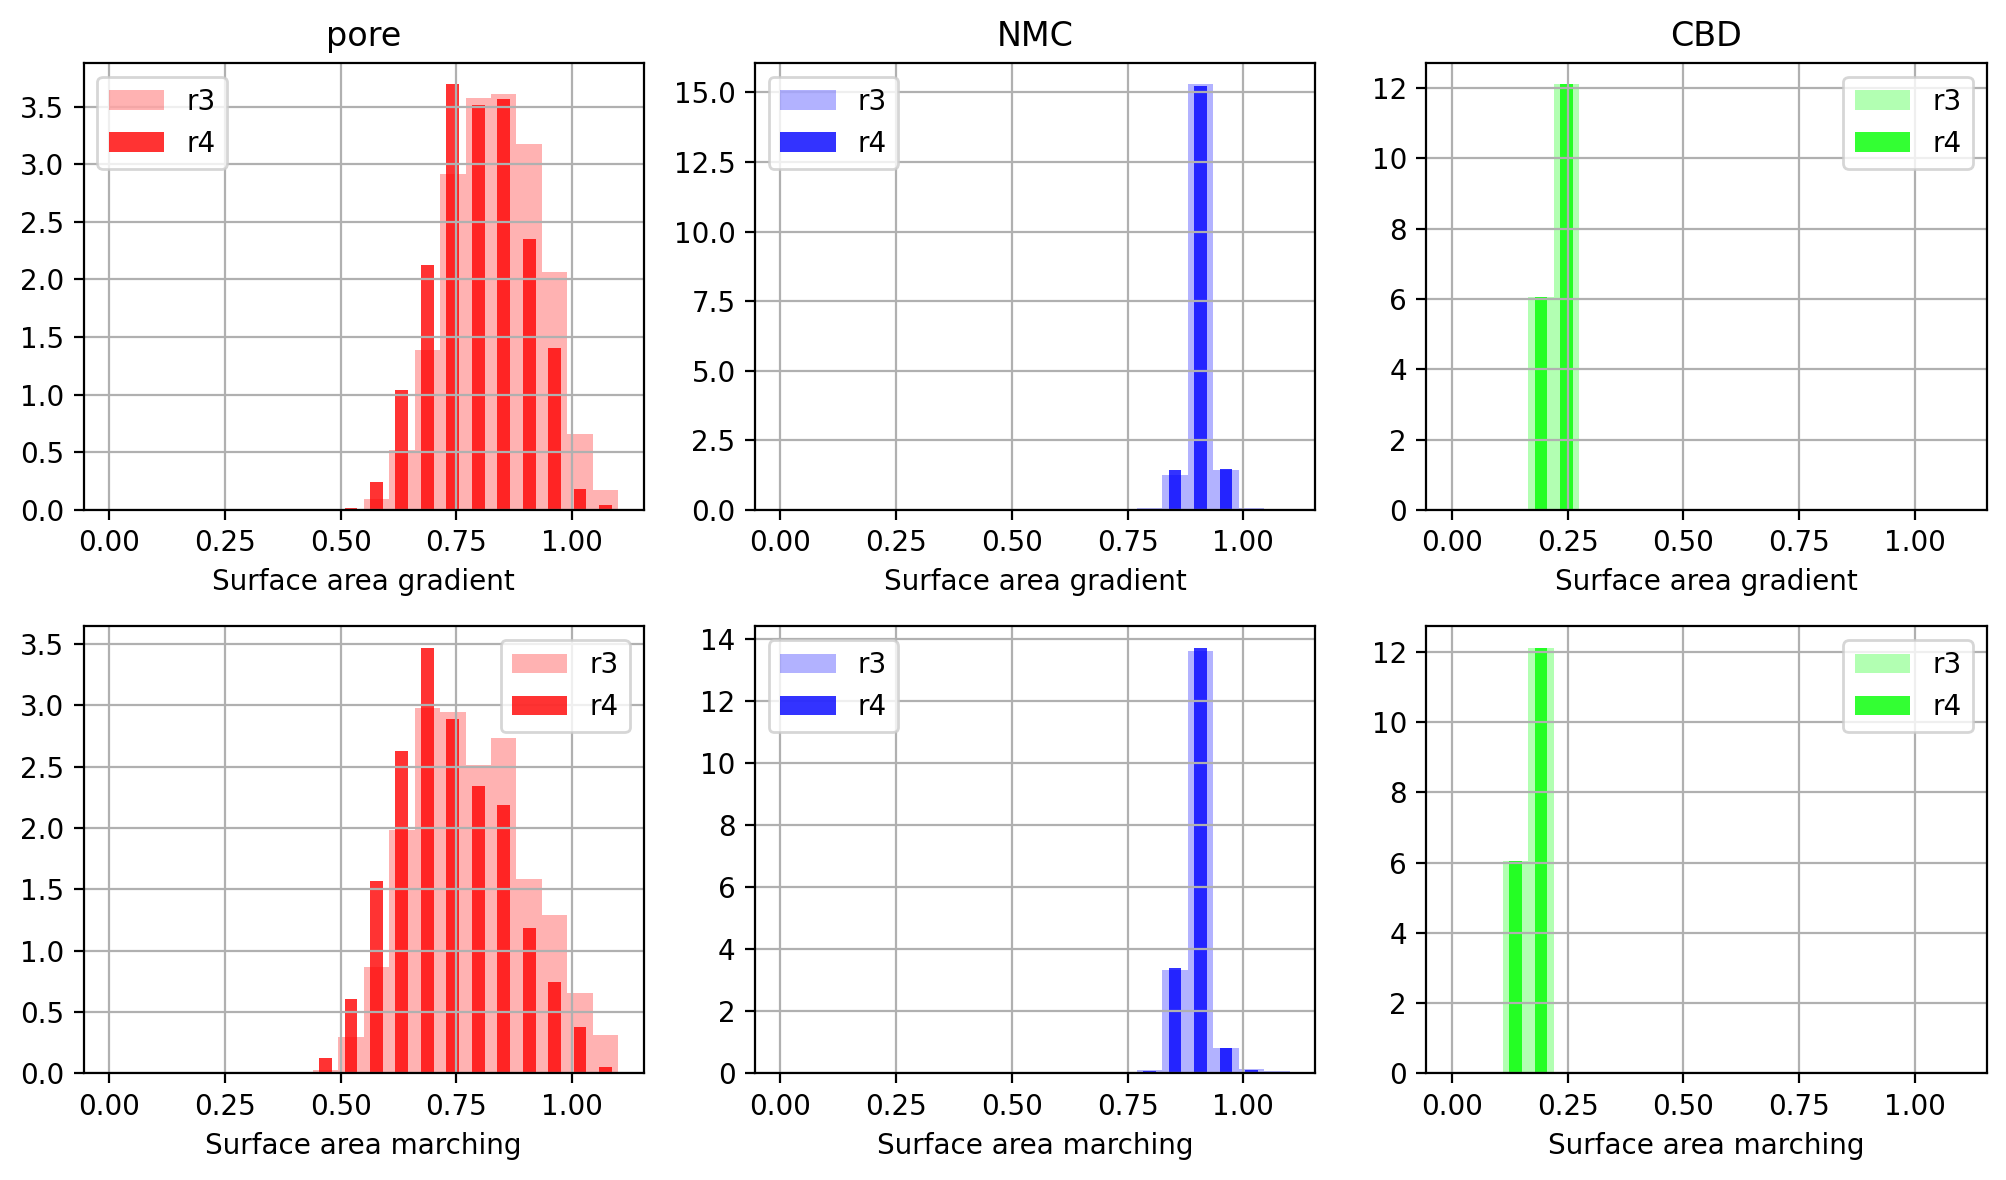

In [13]:
fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(nrows=2, ncols=3, figsize=(10, 6), dpi=200)
axes = [ax0, ax1, ax2, ax3, ax4, ax5]
range = 1.1
bins = 20
i = 0
for key, value in labels.items():
    axes[i].hist((4*np.pi*radii_r3[key]**2)/(surf_gradient_r3[key]*box_volume), bins=bins, density=True, range=(0,range), alpha=0.3, label='r3', color=colors[i])
    axes[i].hist((4*np.pi*radii_r4[key]**2)/(surf_gradient_r4[key]*box_volume), bins=bins, rwidth=0.5, density=True, range=(0,range), alpha=0.8, label='r4', color=colors[i])
    axes[i].set_title(key)
    axes[i].set_xlabel('Surface area gradient')
    axes[i].legend()
    axes[i].grid()
    i = i + 1

for key, value in labels.items():
    axes[i].hist((4*np.pi*radii_r3[key]**2)/(surf_marching_r3[key]*box_volume), bins=bins, density=True, range=(0,range), alpha=0.3, label='r3', color=colors[i])
    axes[i].hist((4*np.pi*radii_r4[key]**2)/(surf_marching_r4[key]*box_volume), bins=bins, rwidth=0.5, density=True, range=(0,range), alpha=0.8, label='r4', color=colors[i])
    axes[i].set_xlabel('Surface area marching')
    axes[i].legend()
    axes[i].grid()
    i = i + 1
plt.tight_layout()
plt.show()

In [14]:
for key, value in labels.items():
    print('Mean sphericity of '+key+f': {np.mean((4*np.pi*radii_r4[key]**2)/(surf_gradient_r4[key]*box_volume))}')

for key, value in labels.items():
    name = 'sphericity_hist_'+key+'.txt'
    data.export_histogram((4*np.pi*radii_r4[key]**2)/(surf_gradient_r4[key]*box_volume), bins=bins, density=True, range=(0,range), filename=name)

Mean sphericity of pore: 0.8012783603278367
Mean sphericity of NMC: 0.911842289123356
Mean sphericity of CBD: 0.2206100100255015
